In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
from src.resnet_yolo import resnet152, retinanet, fasterrcnn, maskRcnn

from torchvision.models.detection import retinanet_resnet50_fpn, fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights

import matplotlib.pyplot as plt
import collections
import darmo

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install opencv-python

In [3]:
#!pip install darmo

## Initialization

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
print(device)

cuda:0


In [6]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [7]:
load_network_path =None #'checkpoints_resnet50/best_detector.pth'#'checkpoints/best_detector.pth'  #'checkpoints_fastrcnn/best_detector.pth' 
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    #net = fasterrcnn().to(device)
    net = maskRcnn().to(device)
    #net = resnet50().to(device)
    
    #net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    #net = resnet50(pretrained=pretrained).to(device)
    #net = resnet152(pretrained=pretrained).to(device)
    #net = retinanet(pretrained=pretrained).to(device)
    #net = fasterrcnn(pretrained=pretrained).to(device)
    net = maskRcnn(pretrained=pretrained).to(device)

Load pre-trained model


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
learning_rate = 0.001
num_epochs = 40
batch_size = 24  

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [9]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [10]:
file_root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [11]:
#!sh download_data.sh

In [12]:
data = train_dataset[0]

## Set up training tools

In [13]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4)

## Train detector

In [14]:
best_test_loss = np.inf
#best_test_loss = 2.69353
#best_test_loss = 3.44532
#best_test_loss = 4.72298
learning_rate = 1e-2
for epoch in range(num_epochs):
    net.train()
    

    # Update learning rate late in training
    if epoch == 5 or epoch == 25 or epoch == 35:
        learning_rate /= 10

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = collections.defaultdict(int)
    
    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    
    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data
            
            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints_maskrcnn/best_detector.pth')
    
    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints_maskrcnn/detector_epoch_%d.pth' % (epoch+1))

        
    torch.save(net.state_dict(),'checkpoints_maskrcnn/detector.pth')
    




Starting epoch 1 / 40
Learning Rate for this epoch: 0.01
Epoch [1/40], Iter [50/209], Loss: total=13.432, reg=78.415, containing_obj=11.692, no_obj=74.909, cls=157.360
Epoch [1/40], Iter [100/209], Loss: total=9.540, reg=70.877, containing_obj=12.633, no_obj=37.456, cls=107.997
Epoch [1/40], Iter [150/209], Loss: total=8.118, reg=67.090, containing_obj=13.309, no_obj=24.972, cls=89.461
Epoch [1/40], Iter [200/209], Loss: total=7.330, reg=64.455, containing_obj=13.656, no_obj=18.730, cls=79.075
Updating best test loss: 5.50315


Starting epoch 2 / 40
Learning Rate for this epoch: 0.01
Epoch [2/40], Iter [50/209], Loss: total=5.189, reg=60.014, containing_obj=15.538, no_obj=0.004, cls=48.988
Epoch [2/40], Iter [100/209], Loss: total=5.069, reg=58.004, containing_obj=15.752, no_obj=0.004, cls=47.890
Epoch [2/40], Iter [150/209], Loss: total=5.041, reg=57.278, containing_obj=15.993, no_obj=0.004, cls=47.712
Epoch [2/40], Iter [200/209], Loss: total=4.993, reg=56.655, containing_obj=16.09

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:13<00:00, 37.07it/s]

---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0---
---class boat ap 0.0---
---class bottle ap 0.0---
---class bus ap 0.0---
---class car ap 0.0--- (no predictions for this class)
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0---
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0--- (no predictions for this class)
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0---
---class train ap 0.0--- (no predictions for this class)
---class tvmonitor ap 0.0003074168356560383---
---map 1.5370841782801914e-05---
4 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

Updating best test loss: 5.01380


Starting epoch 6 / 40
Learning Rate for this epoch: 0.001
Epoch [6/40], Iter [50/209], Loss: total=4.700, reg=52.443, containing_obj=17.736, no_obj=0.007, cls=42.609
Epoch [6/40], Iter [100/209], Loss: total=4.722, reg=52.399, containing_obj=18.213, no_obj=0.007, cls=42.721
Epoch [6/40], Iter [150/209], Loss: total=4.704, reg=51.993, containing_obj=18.094, no_obj=0.007, cls=42.809
Epoch [6/40], Iter [200/209], Loss: total=4.717, reg=52.079, containing_obj=18.403, no_obj=0.007, cls=42.723
Updating best test loss: 4.98428


Starting epoch 7 / 40
Learning Rate for this epoch: 0.001
Epoch [7/40], Iter [50/209], Loss: total=4.765, reg=52.844, containing_obj=18.829, no_obj=0.007, cls=42.676
Epoch [7/40], Iter [100/209], Loss: total=4.764, reg=52.626, containing_obj=18.759, no_obj=0.007, cls=42.943
Epoch [7/40], Iter [150/209], Loss: total=4.718, reg=51.870, containing_obj=18.831, no_obj=0.008, cls=42.523
Epoch [7/40], Iter [200/209], Loss: total=4.666, reg=

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:20<00:00, 35.24it/s]

---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0---
---class boat ap 0.0---
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0---
---class car ap 0.0---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0---
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0---
---class tvmonitor ap 0.0003562011758733071---
---map 1.7810058793665354e-05---
9 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,



Starting epoch 11 / 40
Learning Rate for this epoch: 0.001
Epoch [11/40], Iter [50/209], Loss: total=4.567, reg=50.369, containing_obj=18.755, no_obj=0.008, cls=40.481
Epoch [11/40], Iter [100/209], Loss: total=4.674, reg=51.455, containing_obj=19.081, no_obj=0.008, cls=41.628
Epoch [11/40], Iter [150/209], Loss: total=4.658, reg=50.913, containing_obj=19.138, no_obj=0.008, cls=41.731
Epoch [11/40], Iter [200/209], Loss: total=4.624, reg=50.349, containing_obj=19.016, no_obj=0.008, cls=41.592
Updating best test loss: 4.90960


Starting epoch 12 / 40
Learning Rate for this epoch: 0.001
Epoch [12/40], Iter [50/209], Loss: total=4.581, reg=50.025, containing_obj=19.269, no_obj=0.008, cls=40.636
Epoch [12/40], Iter [100/209], Loss: total=4.528, reg=49.261, containing_obj=18.920, no_obj=0.008, cls=40.487
Epoch [12/40], Iter [150/209], Loss: total=4.580, reg=49.605, containing_obj=19.160, no_obj=0.008, cls=41.157
Epoch [12/40], Iter [200/209], Loss: total=4.611, reg=49.941, containing_obj=

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:17<00:00, 35.97it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0---
---class boat ap 0.00027159152634437803---
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0---
---class car ap 0.0---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0---
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0---
---class motorbike ap 0.0---
---class person ap 0.0---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0---
---class tvmonitor ap 0.0---
---map 1.3579576317218901e-05---
14 [0.0, 0.0, 0.0, 0.00027159152634437803, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Updating best test los

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:14<00:00, 36.72it/s]

---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0---
---class boat ap 0.0---
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0---
---class car ap 0.0---
---class cat ap 0.0---
---class chair ap 0.0---
---class cow ap 0.0---
---class diningtable ap 0.0---
---class dog ap 0.0---
---class horse ap 0.0---
---class motorbike ap 0.0---
---class person ap 0.0---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0---
---class train ap 0.0---
---class tvmonitor ap 9.018759018759019e-05---
---map 4.509379509379509e-06---
19 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.018759018759019e-05]




Starting epoch 21 / 40
Learning Rate for this epoch: 0.001
Epoch [21/40], Iter [50/209], Loss: total=4.599, reg=49.637, containing_obj=19.836, no_obj=0.009, cls=40.893
Epoch [21/40], Iter [100/209], Loss: total=4.650, reg=49.991, containing_obj=20.206, no_obj=0.009, cls=41.389
Epoch [21/40], Iter [150/209], Loss: total=4.569, reg=49.018, containing_obj=19.945, no_obj=0.009, cls=40.684
Epoch [21/40], Iter [200/209], Loss: total=4.544, reg=48.877, containing_obj=19.974, no_obj=0.009, cls=40.184


Starting epoch 22 / 40
Learning Rate for this epoch: 0.001
Epoch [22/40], Iter [50/209], Loss: total=4.675, reg=50.285, containing_obj=21.198, no_obj=0.010, cls=40.703
Epoch [22/40], Iter [100/209], Loss: total=4.606, reg=49.520, containing_obj=20.594, no_obj=0.010, cls=40.411
Epoch [22/40], Iter [150/209], Loss: total=4.591, reg=49.388, containing_obj=20.399, no_obj=0.010, cls=40.389
Epoch [22/40], Iter [200/209], Loss: total=4.534, reg=48.566, containing_obj=20.167, no_obj=0.010, cls=40.064


100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:23<00:00, 34.58it/s]

---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0---
---class boat ap 0.0---
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.0---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0---
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0---
---class person ap 0.0---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0---
---class train ap 0.0---
---class tvmonitor ap 0.0---
---map 0.0---
24 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]




Starting epoch 26 / 40
Learning Rate for this epoch: 0.0001
Epoch [26/40], Iter [50/209], Loss: total=4.373, reg=46.741, containing_obj=19.957, no_obj=0.010, cls=38.242
Epoch [26/40], Iter [100/209], Loss: total=4.400, reg=47.066, containing_obj=19.961, no_obj=0.010, cls=38.571
Epoch [26/40], Iter [150/209], Loss: total=4.461, reg=47.779, containing_obj=20.240, no_obj=0.010, cls=39.030
Epoch [26/40], Iter [200/209], Loss: total=4.470, reg=47.784, containing_obj=20.297, no_obj=0.010, cls=39.197
Updating best test loss: 4.78143


Starting epoch 27 / 40
Learning Rate for this epoch: 0.0001
Epoch [27/40], Iter [50/209], Loss: total=4.345, reg=46.138, containing_obj=20.158, no_obj=0.010, cls=37.967
Epoch [27/40], Iter [100/209], Loss: total=4.476, reg=48.202, containing_obj=20.583, no_obj=0.010, cls=38.632
Epoch [27/40], Iter [150/209], Loss: total=4.454, reg=47.704, containing_obj=20.425, no_obj=0.010, cls=38.747
Epoch [27/40], Iter [200/209], Loss: total=4.463, reg=47.702, containing_ob

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:12<00:00, 37.26it/s]

---class aeroplane ap 0.0---
---class bicycle ap 0.0---
---class bird ap 0.0---
---class boat ap 0.0003802281368821293---
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.0---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0---
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0---
---class train ap 0.0---
---class tvmonitor ap 0.00020292207792207794---
---map 2.9157510740210364e-05---
29 [0.0, 0.0, 0.0, 0.0003802281368821293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Updating best test loss: 4.75540


Starting epoch 31 / 40
Learning Rate for this epoch: 0.0001
Epoch [31/40], Iter [50/209], Loss: total=4.493, reg=48.270, containing_obj=20.224, no_obj=0.011, cls=39.329
Epoch [31/40], Iter [100/209], Loss: total=4.473, reg=47.932, containing_obj=20.339, no_obj=0.010, cls=39.077
Epoch [31/40], Iter [150/209], Loss: total=4.422, reg=47.318, containing_obj=20.218, no_obj=0.010, cls=38.587
Epoch [31/40], Iter [200/209], Loss: total=4.471, reg=47.903, containing_obj=20.387, no_obj=0.010, cls=38.998
Updating best test loss: 4.75146


Starting epoch 32 / 40
Learning Rate for this epoch: 0.0001
Epoch [32/40], Iter [50/209], Loss: total=4.301, reg=45.205, containing_obj=20.139, no_obj=0.010, cls=37.879
Epoch [32/40], Iter [100/209], Loss: total=4.401, reg=46.351, containing_obj=20.414, no_obj=0.010, cls=38.843
Epoch [32/40], Iter [150/209], Loss: total=4.460, reg=47.404, containing_obj=20.367, no_obj=0.010, cls=39.256
Epoch [32/40], Iter [200/209], Loss: total

100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:21<00:00, 35.02it/s]

---class aeroplane ap 0.0---
---class bicycle ap 0.0---
---class bird ap 0.0---
---class boat ap 0.0---
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0---
---class car ap 0.0---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0---
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0---
---class motorbike ap 0.0---
---class person ap 1.226933647428347e-05---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0---
---class train ap 0.0---
---class tvmonitor ap 0.00017088174982911826---
---map 9.157554315170087e-06---
34 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.226933647428347e-05, 0.0, 0.0, 0.0, 0.0, 0.00017088174982911826]




Starting epoch 36 / 40
Learning Rate for this epoch: 1e-05
Epoch [36/40], Iter [50/209], Loss: total=4.411, reg=46.972, containing_obj=20.361, no_obj=0.010, cls=38.524
Epoch [36/40], Iter [100/209], Loss: total=4.431, reg=47.606, containing_obj=20.269, no_obj=0.010, cls=38.464
Epoch [36/40], Iter [150/209], Loss: total=4.469, reg=48.094, containing_obj=20.400, no_obj=0.010, cls=38.749
Epoch [36/40], Iter [200/209], Loss: total=4.435, reg=47.645, containing_obj=20.251, no_obj=0.010, cls=38.542


Starting epoch 37 / 40
Learning Rate for this epoch: 1e-05
Epoch [37/40], Iter [50/209], Loss: total=4.520, reg=48.082, containing_obj=20.764, no_obj=0.010, cls=39.612
Epoch [37/40], Iter [100/209], Loss: total=4.511, reg=48.330, containing_obj=20.658, no_obj=0.010, cls=39.273
Epoch [37/40], Iter [150/209], Loss: total=4.458, reg=47.734, containing_obj=20.420, no_obj=0.010, cls=38.840
Epoch [37/40], Iter [200/209], Loss: total=4.476, reg=47.881, containing_obj=20.533, no_obj=0.010, cls=39.012


100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:19<00:00, 35.56it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0---
---class bird ap 0.0---
---class boat ap 0.0007604562737642586---
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0---
---class car ap 0.0---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0---
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0---
---class motorbike ap 0.0---
---class person ap 1.5774861181221605e-05---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0---
---class train ap 0.0---
---class tvmonitor ap 0.00017088174982911826---
---map 4.7355644238729926e-05---
39 [0.0, 0.0, 0.0, 0.0007604562737642586, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5774861181221605e-05, 0.0, 0.0, 0.0, 0.0, 0.00017088174982911826]


# View example predictions

predicting...


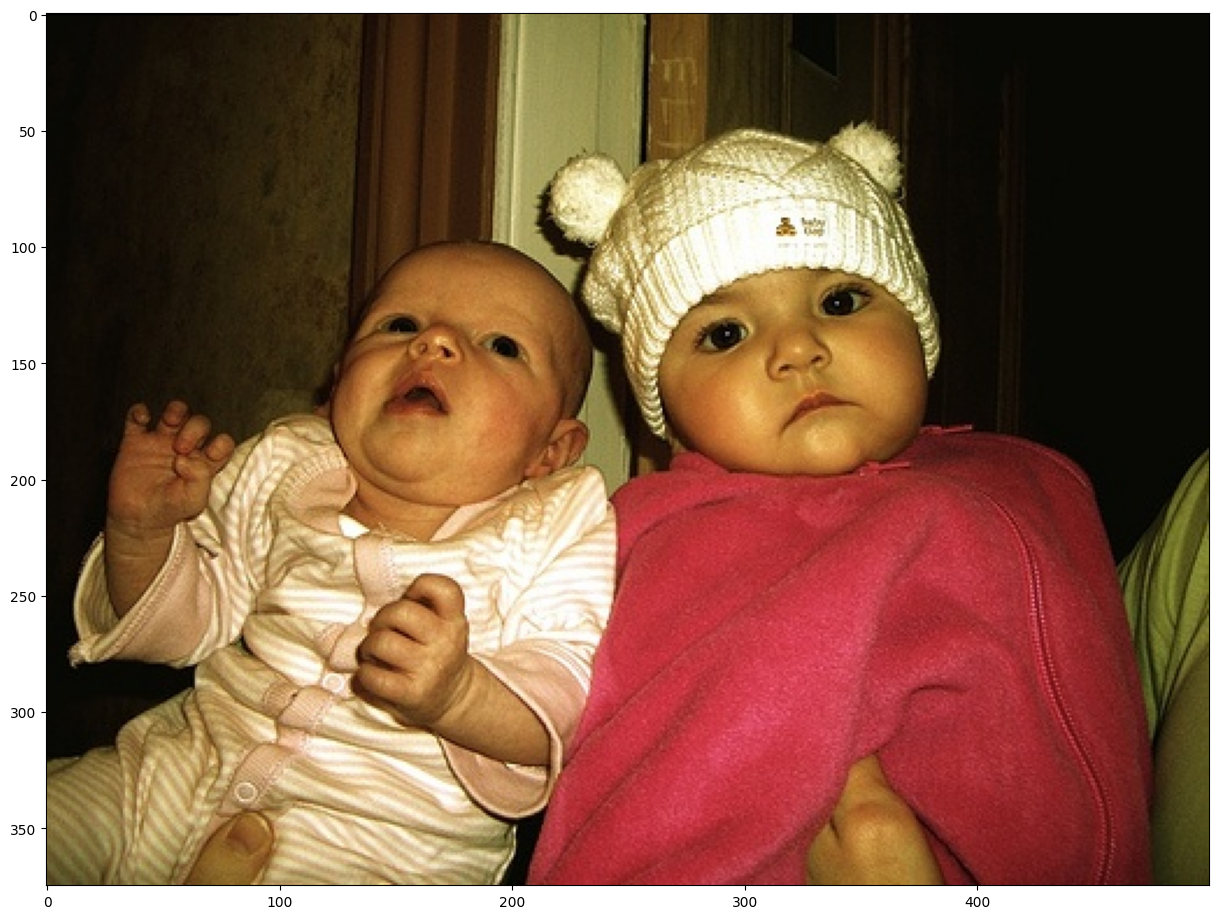

In [15]:
net.eval()

# select random image from test set

image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [16]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████████████████████████████████████████████████████████████████| 4950/4950 [02:17<00:00, 35.88it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0---
---class bird ap 0.0---
---class boat ap 0.0007604562737642586---
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0---
---class car ap 0.0---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0---
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0---
---class motorbike ap 0.0---
---class person ap 1.5774861181221605e-05---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0---
---class train ap 0.0---
---class tvmonitor ap 0.00017088174982911826---
---map 4.7355644238729926e-05---


### Cell added to get intermediate mAP values for students

In [17]:
network_paths = ['checkpoints_maskrcnn/detector_epoch_%d.pth' % epoch for epoch in [5, 10, 20, 30, 40]]+['checkpoints_maskrcnn/detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test,img_root=file_root_test)


Loading saved network from /detector_epoch_5.pth


FileNotFoundError: [Errno 2] No such file or directory: '/detector_epoch_5.pth'

In [ ]:
output_submission_csv('my_new_solution_3.csv', test_aps)